In [1]:
#from time import time

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from my_fun import read_feature
from my_fun import run_model
from my_fun import get_feature

brain_feature_list, subject_info_merge = read_feature()

# remove samples with Med_rating higher than 1:
# subject_info_merge = subject_info_merge.loc[subject_info_merge["Med_Rating"]<2]
    
# subject_info_merge.to_csv("subject_info_merge.csv", sep = ",")



(165, 4)
(8719, 6)
cat_vbm:
(856, 143)
label fa:
(856, 50)
tract fa:
(856, 20)
tract md:
(856, 20)
label md:
(856, 50)
alff
(856, 246)
falff
(856, 246)
reho
(856, 246)


In [2]:
print("participants:")
print("number of subjects: %d" % subject_info_merge.shape[0])
print("meam  and std of age: %.2f %.2f" % (subject_info_merge["age_at_cnb"].mean(),\
                                           subject_info_merge["age_at_cnb"].std()))
print("range of age: %d - %d" % (subject_info_merge["age_at_cnb"].max(),\
                                 subject_info_merge["age_at_cnb"].min()))

print("number of females: %d" % subject_info_merge.loc[subject_info_merge['Sex_x']==0,:].shape[0])
print("number of males: %d" % subject_info_merge.loc[subject_info_merge['Sex_x']==1,:].shape[0])


subject_info_hc = subject_info_merge

# subject_info_hc = subject_info_merge.loc[subject_info_merge["ptsd"]==0]
# subject_info_ptsd = subject_info_merge.loc[subject_info_merge["ptsd"]==2]
# subject_info_trauma = subject_info_merge.loc[subject_info_merge["ptsd"]==1]

participants:
number of subjects: 839
meam  and std of age: 14.37 3.37
range of age: 21 - 8
number of females: 451
number of males: 388


In [3]:
from sklearn.model_selection import KFold

# tune model in n-fold CV:
# n fold CV on hc data:
nfold = 10
seed = 111
kf = KFold(n_splits=nfold, shuffle = True, random_state=seed)

In [30]:
############################################# DNN (pytorch) #######################################
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

# from skorch import NeuralNetClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from collections import OrderedDict

torch.manual_seed(999)    # reproducible
# https://discuss.pytorch.org/t/size-mismatch-beginner-troubles/16789
# model setup

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


def weights_init(m):
    if isinstance(m, nn.Linear):
        print('initialize weight...')
        nn.init.xavier_uniform_(m.weight.data) 

def create_plot():
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    plt.ion() #Turn the interactive mode on.
    fig.show()
    fig.canvas.draw()
    return(fig)
    
    
def update_plot(fig, plot_list, loss_info):
    
    ax = plt.gca()
    plt.ion() #Turn the interactive mode on.
    ax.clear()
    
    color = [['r--', 'b--'], ['g--', 'y--']]
    
    for i in range(len(plot_list)):
        i_list = plot_list[i]
        i_list_s = smooth(i_list, box_pts = 100)
        epoch = len(i_list)
        ax.plot(range(epoch), i_list, color[i][0], i_list_s, color[i][1])
    
    plt.ylim(0, 30) 
    plt.text(10, 30 , loss_info, fontsize=10)
    fig.canvas.draw()
    
def end_plot(fig, plot_list, loss_info, opt_loss_info, opt_epochs):
    plt.ion() #Turn the interactive mode on.
    ax = plt.gca()
    ax.clear()
    color = [['r--', 'b--'], ['g--', 'y--']]
    
    for i in range(len(plot_list)):
        i_list = plot_list[i]
        i_list_s = smooth(i_list, box_pts = 100)
        epoch = len(i_list)
        ax.plot(range(epoch), i_list, color[i][0], i_list_s, color[i][1])
        
    plt.ylim(0, 30) 
    plt.text(10, 30 , loss_info, fontsize=10)
    plt.text(10, 20 , opt_loss_info, fontsize=10)
    ax.axvline(opt_epochs)
    fig.canvas.draw()
    

def transform_variable(X, y):
    
    X_train_torch = Variable(torch.from_numpy(X))
    y_train_torch = Variable(torch.from_numpy(y))
    
    X_train_torch = X_train_torch.float()
    y_train_torch = y_train_torch.float()

    labels = y_train_torch.view(y.shape[0],1)
    
    return (X_train_torch, labels)


class Model(nn.Module): 
    
    def __init__(self, min_loss = .5, l_rate = .001, max_epochs = 10000):
        
        super(Model, self).__init__() 
        self.min_loss = min_loss
        self.l_rate = l_rate
        self.max_epochs = max_epochs
    
        
    def build_layer(self, input_dim):
        
        if input_dim<100:
            n_units = [input_dim, 200, 100, 50, 20, 1]
        elif input_dim<200:
            #n_units = [input_dim, 100, 100, 50, 20, 1] 
            n_units = [input_dim, 50, 50, 30, 5, 1]
        elif input_dim<300:
            n_units = [input_dim, 200, 100, 50, 20, 1]      
        else:
            n_units = [input_dim, 400, 150, 50, 30, 5, 1]
        
        
        self.sigmoid = torch.nn.Sigmoid()
        self.n_layers = len(n_units)-1
        
        layers = OrderedDict()
        for i in range(self.n_layers):
            n_hidden = n_units[i]
            n_hidden2 = n_units[i+1]
            
            layers[str(i)] = nn.Linear(n_hidden, n_hidden2)
            
        self.layers = nn.Sequential(layers)  
        print("build layer:")
        print(self)
        
        self.optimizer = torch.optim.SGD(self.parameters(), 
                                    lr = self.l_rate, 
                                    weight_decay=1e-3, 
                                    momentum=0.9, 
                                    dampening = 0,
                                    nesterov=True) #Stochastic Gradient Descent 
        
        #self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=500, gamma=.8)
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, 
                                                              milestones=[500, 1000, 1500, 3000, 6000], 
                                                              gamma=0.5)
        
#         optimizer = torch.optim.Adagrad(self.parameters(), 
#                                         lr = self.l_rate, 
#                                         lr_decay = 1e-9,
#                                         weight_decay=1e-9,
#                                        )

        self.criterion = nn.MSELoss()# Mean Squared Loss
    
    def forward (self, x, **kwargs):

        for i in range(self.n_layers):
            #layer = eval('self.layer' + str(i+1))
            layer = self.layers[i]
            
            if i==0:
                # the 1st layer:
                out = F.relu(layer(x))
                #out = self.dropout(out)
            elif i<self.n_layers-2:
                # the middle layers use sigmoid.
                out = self.sigmoid(layer(out))
                #out = self.dropout(out)
            elif i==self.n_layers-2:
                out = F.relu(layer(out))
                #out = self.dropout(out)
            else:
                y_pred = layer(out) # linear output
            
        return y_pred
    
    
    def grad_decent(self, X_train_torch, labels):
        self.scheduler.step()
        #clear grads 
        self.optimizer.zero_grad()
        #forward to get predicted values
        outputs = self(X_train_torch) # model predict,  outputs = net.forward(inputs)

        loss = self.criterion(outputs, labels)
        loss.backward()# back props
        self.optimizer.step()# update the parameters 
        self.loss = loss
    
    
    def fit (self, X, y):
        """
        Fit model with all the input samples. It is recommended to first use fit_cv to determined the 
        optimized value of min_loss.
        """
        min_loss = self.min_loss
        max_epochs = self.max_epochs
        
        #torch.manual_seed(999)    # reproducible
        self.build_layer(input_dim = X.shape[1])

        torch.manual_seed(999) 
        self.apply(weights_init)
        print('training with all training data:')
        opt_loss_mean = -9999

        X_train_torch, labels = transform_variable(X, y)

        loss_list = []
        epoch = 0
        fig = create_plot()
        while True:            
            #increase the number of epochs by 1 every time
            epoch +=1

            self.grad_decent(X_train_torch, labels)
            loss = self.loss.item()
            loss_list = np.append(loss_list, loss)

            if epoch % 100 == 0:
                loss_info = 'epoch %d, loss %.4f' % (epoch, loss)
                update_plot(fig, [loss_list], loss_info)
                fig.canvas.draw()

            # define the mean loss to prevent overfitting.
            if loss<min_loss or epoch>max_epochs:
                print('stop with loss', loss)
                break
    
    
    def fit_cv (self, X_train, y_train, X_test, y_test):
        """
        Use test data to compute validation accuracy.
        """
        
        min_loss = self.min_loss
        max_epochs = self.max_epochs
        
        #torch.manual_seed(999)    # reproducible
        self.build_layer(input_dim = X.shape[1])
        X_train_torch, labels = transform_variable(X_train, y_train)

        # Collect errors to evaluate performance
        loss_list = []
        corr_list = []

        torch.manual_seed(999) 
        self.apply(weights_init)

        epoch = 0
        fig = create_plot()
        while True:

            #increase the number of epochs by 1 every time
            epoch +=1

            self.grad_decent(X_train_torch, labels)
            loss = self.loss.item()

            y_prediction = self.predict(X_test)

            corr = np.corrcoef(y_prediction, y_test)[0,1]
            corr_list = np.append(corr_list, corr) 
            loss_list = np.append(loss_list, loss)

            max_corr = np.amax(corr_list)

            if epoch % 100 == 0:
                loss_info = 'epoch %d, loss %.4f, test cor %.4f' % (epoch, loss, corr)
                update_plot(fig, [loss_list, corr_list*10], loss_info)

            if epoch>max_epochs or loss< min_loss:
                break

        corr_list_s = smooth(corr_list, box_pts = 100)
        opt_epochs = corr_list_s.argmax()
        opt_loss = loss_list[opt_epochs]

        print('max coor at epochs: %d, loss %.4f, with test cor: %.4f' % 
              (opt_epochs, opt_loss, corr_list[opt_epochs]))

        loss_info = 'epoch %d, loss %.4f, test cor %.4f' % (epoch, loss, corr)

        opt_loss_info = 'opt_epoch %d, opt_loss %.4f, test cor %.4f' % \
            (opt_epochs, opt_loss, corr_list[opt_epochs])

        update_plot(fig, [loss_list, corr_list*10], loss_info)
        end_plot(fig, [loss_list, corr_list*10], loss_info, opt_loss_info, opt_epochs)

        
        return(opt_loss)

    
    def predict(self, X_test):
        
        X_test_torch = Variable(torch.from_numpy(X_test))
        X_test_torch = X_test_torch.float()
        
        y_prediction = self(X_test_torch)
        y_prediction = y_prediction.detach().numpy().flatten()
        
        return y_prediction



MD
(838, 70)
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


<IPython.core.display.Javascript object>


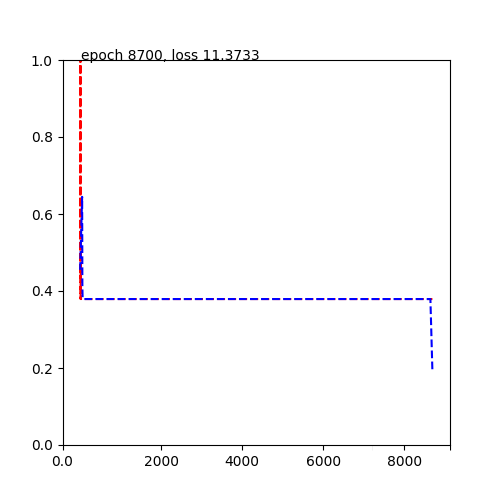

KeyboardInterrupt: 

In [31]:
# MD:
%matplotlib notebook

idx = 4

brain_feature = brain_feature_list[idx][0]
feature_name = brain_feature_list[idx][1]
print(feature_name)
# print(brain_feature.shape)
# print(brain_feature[0:5])

X, y = get_feature(brain_feature, subject_info_hc)
print(X.shape)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=999)
net = Model(min_loss = .5, l_rate = 1e-3, max_epochs = 15000)

opt_loss_list = []
for train_index, test_index in sss.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    opt_loss = net.fit_cv(X_train, y_train, X_test, y_test)
    opt_loss_list = np.append(opt_loss_list, opt_loss)
    #net.fit(X_train, y_train)

opt_loss_mean = np.nanmean(opt_loss_list)
print('boots finished with optimized loss: %.4f' %opt_loss_mean)

Multi-modal
(838, 772)
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=772, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
)


<IPython.core.display.Javascript object>


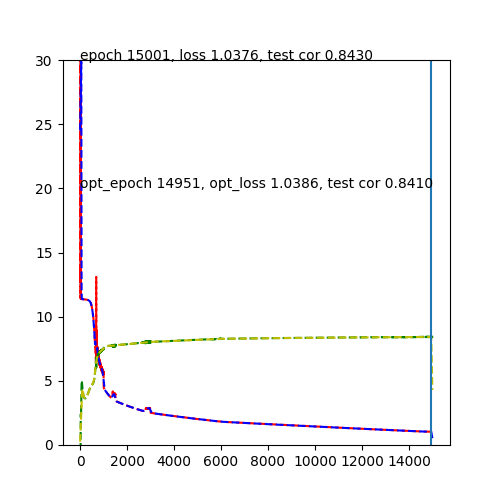

max coor at epochs: 14951, loss 1.0386, with test cor: 0.8410
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=772, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)


<IPython.core.display.Javascript object>


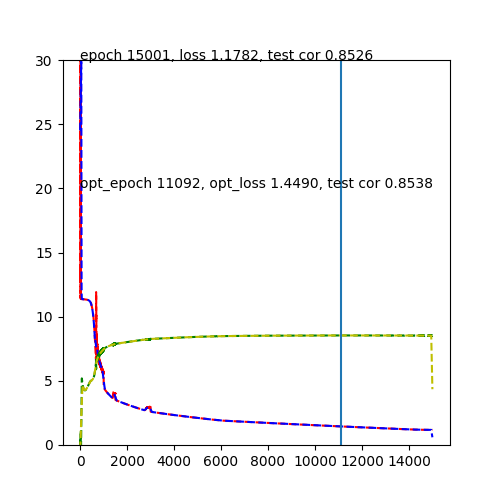

max coor at epochs: 11092, loss 1.4490, with test cor: 0.8538
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=772, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)


<IPython.core.display.Javascript object>


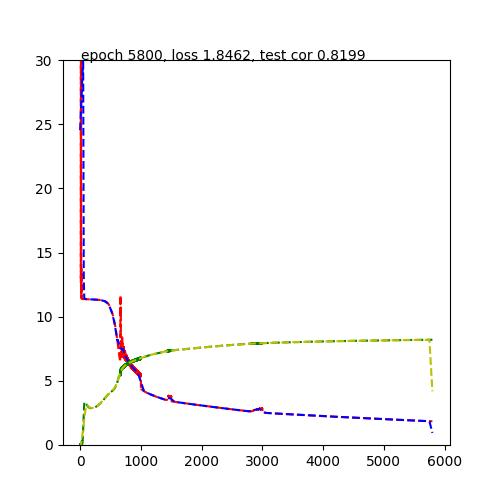

KeyboardInterrupt: 

In [13]:
# multi-modal:
%matplotlib notebook

idx = 5

brain_feature = brain_feature_list[idx][0]
feature_name = brain_feature_list[idx][1]
print(feature_name)
# print(brain_feature.shape)
# print(brain_feature[0:5])

X, y = get_feature(brain_feature, subject_info_hc)
print(X.shape)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
net = Model(min_loss = .5, l_rate = 1e-3, max_epochs = 15000)

opt_loss_list = []
for train_index, test_index in sss.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    opt_loss = net.fit_cv(X_train, y_train, X_test, y_test)
    opt_loss_list = np.append(opt_loss_list, opt_loss)

opt_loss_mean = np.nanmean(opt_loss_list)
print('boots finished with optimized loss: %.4f' %opt_loss_mean)